In [1]:
import os
from pathlib import Path
import json
from collections import defaultdict
from itertools import combinations, permutations
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
e2e_train_path = Path(os.getenv("CURRICULA_DATA")) / "E2E" / "E2E.train.no-ol.jsonl"
viggo_train_path = Path(os.getenv("CURRICULA_DATA")) / "ViGGO" / "ViGGO.train.jsonl"

In [3]:
def load_dataset(path):
    ds = []
    with path.open('r') as fp:
        for line in fp:
            ex = json.loads(line)
            if ex['source']['mr']['da'] == 'inform':
                ds.append(ex)
    return ds


# Load E2E and ViGGO examples 
- only loading examples where the dialog act (da) = 'inform'
- that is all E2E and the majority of ViGGO examples

In [4]:
e2e_train = load_dataset(e2e_train_path)
viggo_train = load_dataset(viggo_train_path)
DS = {'E2E': e2e_train, 'ViGGO': viggo_train}

# Compute some dataset stats (see below for details)

In [5]:
def get_attr2val(ds, has_header=False):
    a2v = {
        'lex': defaultdict(set),
        'delex': defaultdict(set),
    }
    
    for ex in ds:
        seq = ex['source']['sequence']['rule_lex']
        if has_header:
            seq = seq[2:]
        for av in seq:
            a, v = av.split("=")
            a2v['lex'][a].add(v)
        
        seq = ex['source']['sequence']['rule_delex']
        if has_header:
            seq = seq[2:]
        for av in seq:
            a, v = av.split("=")
            a2v['delex'][a].add(v)
    return a2v
            
attr2vals = {'E2E': get_attr2val(e2e_train), 'ViGGO': get_attr2val(viggo_train, has_header=True)}

In [6]:
def get_found_attrsXattrs(ds):
    found = set()
    for ex in DS[ds]:
        seq = ex['source']['sequence']['rule_lex'] 
        if ds == 'ViGGO':
            seq = seq[2:]
        for av1, av2 in zip(seq[:-1], seq[1:]):
            a1, _ = av1.split("=")
            a2, _ = av2.split("=")
            found.add((a1, a2))
    return len(found)

def get_e2e_attr_value_pairs(delex):
    attr_val_pairs = 0
    for a1, a2 in permutations(list(attr2vals['E2E'][delex].keys()), 2):
        attr_val_pairs += len(attr2vals['E2E'][delex][a1]) * len(attr2vals['E2E'][delex][a2])
    return attr_val_pairs

def get_viggo_attr_value_pairs(delex):
    attr_val_pairs = 0
    for a1 in attr2vals['ViGGO'][delex]:
        for a2 in attr2vals['ViGGO'][delex]:
            if a1 != a2:
                attr_val_pairs += len(attr2vals['ViGGO'][delex][a1]) * len(attr2vals['ViGGO'][delex][a2])
            elif a1 in ['genres', 'platforms', 'player_perspective']:
                attr_val_pairs += len(attr2vals['ViGGO'][delex][a1]) * (len(attr2vals['ViGGO'][delex][a2]) - 1)
    return attr_val_pairs
    

def get_observed_attr_value_pairs(ds, delex):
    found = set()
    for ex in DS[ds]:
        seq = ex['source']['sequence'][f'rule_{delex}'] 
        if ds == 'ViGGO':
            seq = seq[2:]
        for av1, av2 in zip(seq[:-1], seq[1:]):
            found.add((av1, av2))
    return len(found)

stats = []
for ds in ['E2E', 'ViGGO']:
    ds_stats = {}
    ds_stats['unique attributes'] = len(attr2vals[ds]['lex'])
    ds_stats['avg values/attribute (lex)'] =  sum([len(y) for y in attr2vals[ds]['lex'].values()]) / len(attr2vals[ds]['lex'])
    ds_stats['avg values/attribute (delex)'] =  sum([len(y) for y in attr2vals[ds]['delex'].values()]) / len(attr2vals[ds]['delex'])
    ds_stats['legal attribute transitions'] = len(attr2vals[ds]['lex']) * (len(attr2vals[ds]['lex']) - 1)
    if ds == 'ViGGO':
        ds_stats['legal attribute transitions'] += 3 # (genres->genres, platforms->platforms, perspective->perspective)
    ds_stats['actual attribute transitions'] = get_found_attrsXattrs(ds)
    if ds == 'E2E':
        ds_stats['legal attribute/value transitions (lex)'] = get_e2e_attr_value_pairs('lex')
        ds_stats['legal attribute/value transitions (delex)'] = get_e2e_attr_value_pairs('delex')
    else:
        ds_stats['legal attribute/value transitions (lex)'] = get_viggo_attr_value_pairs('lex')
        ds_stats['legal attribute/value transitions (delex)'] = get_viggo_attr_value_pairs('delex')
    ds_stats['actual attribute/value transitions (lex)'] = get_observed_attr_value_pairs(ds, 'lex')
    ds_stats['actual attribute/value transitions (delex)'] = get_observed_attr_value_pairs(ds, 'delex')
    ds_stats['# train examples'] = len(DS[ds])
    stats.append(ds_stats)

    
df = pd.DataFrame(stats, index=['E2E', 'ViGGO'])
df.T.round(2)

,E2E,ViGGO
unique attributes,8.00,12.00
avg values/attribute (lex),10.25,22.42
avg values/attribute (delex),3.88,4.17
legal attribute transitions,56.00,135.00
actual attribute transitions,63.00,123.00
legal attribute/value transitions (lex),5028.00,53610.00
legal attribute/value transitions (delex),780.00,2430.00
actual attribute/value transitions (lex),3029.00,2784.00
actual attribute/value transitions (delex),659.00,1029.00
# train examples,33523.00,2379.00


*unique attributes* &mdash; e.g. name, near, area, customer_rating, ...

*avg values / attribute (lex)* &mdash; e.g. area has 2 possible values, 'city centre' or 'riverside', near has ???: Burger King, Crowne Plaza Hotel, ...

*avg values / attribute (delex)* &mdash; e.g. area has 2 possible values, 'city centre' or 'riverside', near has 1: PLACEHOLDER.

*legal attribute transitions* &mdash; if each attribute is only allowed to appear at most once in an MR, how many unique pairwise transitions exist. For ViGGO, certain list valued attributes (genres, platforms, player_perspective) can repeat so we include those in the count.

*actual attribute transitions* &mdash; total number of unique pairwise transitions observed in training data. This includes 'illegal' MRs where the human author mentioned the same attribute multiple times, e.g. `The highly rated Crab Hut serves Chinese food. This excellently rated establishment also has low prices!` where the corresponding attribute sequence is `[customer_rating, name, food, customer_rating, price_range]` or repeated elements, e.g. `The Crab Hut serves Chinese food. For Chinese, it is highly recommended.` has the attribute sequence `[name, food, food, cusomter_rating]`, where we consider the food -> food transition to be not good. 

*legal/actual attribute value transitions (lex/delex)* &mdash; similar to legal and actual attribute transitions, but we count possible/observed `attr1=val1 X attr2=val2` transitions. If delex, the values for certain fields (e.g. name, near)
are replaced with PLACEHOLDER token.

*# train examples* &mdash; training set size

### Some observations

Even with only 8 attributes and delexicalizing name and and near attributes, on E2E there are 780 possible `(attr/val X attr/val)` pairs but we only see 659 of in the training set. The situation on ViGGO is even more extreme, since the dataset is an order of magnitude smaller and as 4 more unique attributes. Depending on your perspective this is either a bug or a feature.
- *Empirical Risk Minimization view* &mdash; humans have ordering preferences and so there are certain transitions that are awkward and thus not well represented (or represented at all) in an empirical sample of human reference texts. The goal of a learning based approach to NLG is to learn this distribution. We cannot expect a learner to perform well outside of this distribution.



- *Systematic/Generalization View* &mdash; humans are capable of realizing any order. We should be trying to learn in away that generalizes beyond the distribution. We conjecture that do so, we need the learner to be aware of the constituent/compositional structure of language. 


If we consider `(attr X attr)` transitions the situation is not as dire. There are only 56 and 135 attribute pair transitions for E2E and ViGGO respectively. In E2E we see all of them (and some funky repeats). On ViGGO we 123 (~91% coverage). If learner is learning something general about attribute transitions, independent of the specific value, then maybe this problem isn't so hard? 

# Curricula 

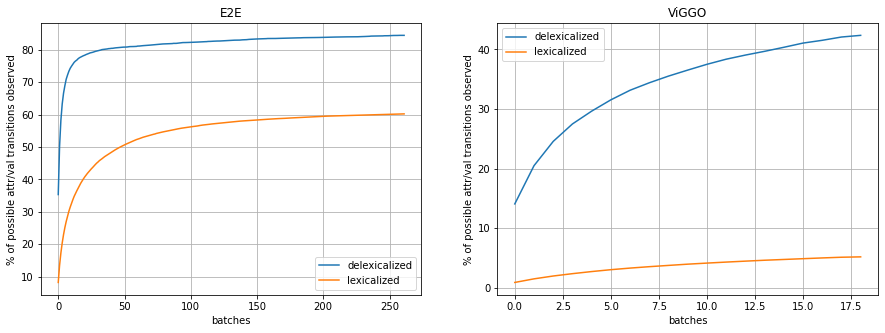

In [7]:
import random
import numpy as np
random.seed(53461451451)

def get_found(ds, delex, bs=128):
    found = set()
    y = []
    divisor = df[f"legal attribute/value transitions ({delex})"][ds]
    for i in range(0, len(DS[ds]), bs):
        for ex in DS[ds][i:i+bs]:
            seq = ex['source']['sequence'][f'rule_{delex}']
            if ds == 'ViGGO':
                seq = seq[2:]
            for av1, av2 in zip(seq[:-1], seq[1:]):
                found.add((av1, av2))
        y.append(100 * len(found) / divisor)
    return y

def avg(ds, delex, bs=128, samples=10):
    Y = []
    for _ in range(samples):
        random.shuffle(DS[ds])
        Y.append(get_found(ds, delex, bs))
    Y = np.array(Y)
    return Y.mean(axis=0)
    
fig, axes = plt.subplots(1,2, figsize=(15, 5))
for i, ds in enumerate(['E2E', 'ViGGO']):
    axes[i].plot(avg(ds, 'delex'), label='delexicalized')
    axes[i].plot(avg(ds, 'lex'), label='lexicalized')
    _ = axes[i].set_xlabel('batches')
    _ = axes[i].set_ylabel('% of possible attr/val transitions observed')
    _ = axes[i].set_title(ds)
    _ = axes[i].legend()
    _ = axes[i].grid()

We plot the coverage of possible `(attr1=val1 X attr2=val2)` over the coarse of single training epoch with batch size 128. On E2E in about 25 steps we see 80% of delexicalized attr/val pair transitions. Would be interesting to compare performance of model where we control the number of seen transitions but keep the dataset size fixed. I think E2E is large enough that we could do that experiment. 

I.e. a table of:

 | data size | coverage of transitions | Test Set BLEU |
 |-----------|-------------------------|---------------|
 | 10,000    | 50%                     | XX.XXX |
 | 10,000         | 60%                                   | XX.XXX |
 | 10,000         | 70%                                   | XX.XXX |
 | ...      | ...                                  | ... |
 
 This would help to establish ceilings/comparisons for various curricula schemes that use a smaller amount of data.
 

 
Regarding few shot learning, I also think the few-shot learning setup is misleading as I believe the learning setup when using a large pretrained lm is:
1. lm pretraining on web scale data
2. nlg fine tuning (fine tune the pretrained lm model (1) on largish/diverse nlg dataset)
3. few shot finetune (fine tune (2) on a handful (0, 1, 5, 50) of nlg examples from new domain)

I think our goal should be to replace (2) with a small causal curriculum, and then evaluate it's effect on in domain evaluation (2) and then few shot out of domain generalization (3). Also we can more rigorously evaluate (3) than previous papers have (i.e. do systematic stress tests similar to my emnlp submission).

# Pointwise Mutual Information of attribute/value transitions

The above analysis does not address the issue of spurious correlations. To get at this I computed the pointwise mutual information (PMI) for `(attr1/val1 X attr2/val2)` and `(attr1 X attr2)` transition pairs. These counts take order into account so `PMI(attr1, attr2) != PMI(attr2, attr1)`. A PMI of 0 means probability of `p(attr1, attr2) ~= p(attr1)p(attr2)`, or the occurance of attr1 is independent of attr2. Values greater than 0 indicate positive association (ie. likely to co-occur), and values less than 0 are negatively associated (likey to not co-occur). If you take the systematic view above, pairs with either strong negative and positive pmi are potentials for spurious correlations to arise.

In [8]:
def make_pmi(ds, delex='delex', include_values=True):
    marg_lps = {} # marginal log probs, i.e. log p(x = area_riverside)
    joint_lps = {} # joint log probs, i.e. log p(x_1= area_riverside, x_2=eat_type_pub)
    total_singletons = 0
    total_pairs = 0
    for ex in DS[ds]:
        seq = ex['source']['sequence'][f'rule_{delex}']
        if ds == 'ViGGO':
            seq = seq[2:]
        seq = ['<sos>'] + seq + ['<eos>']
        total_singletons += len(seq)
        total_pairs += len(seq) - 1
        if include_values:
            for av in seq:
                marg_lps[av] = marg_lps.get(av, 0) + 1
                
            for av1, av2 in zip(seq[:-1], seq[1:]):
                joint_lps[(av1, av2)] = joint_lps.get((av1, av2), 0) + 1
        else:
            for av in seq:
                if '=' in av:
                    a, v = av.split('=')
                else:
                    a = av
                marg_lps[a] = marg_lps.get(a, 0) + 1
            for av1, av2 in zip(seq[:-1], seq[1:]):
                if '=' in av1:
                    a1, v1 = av1.split('=')
                else:
                    a1 = av1
                if '=' in av2:
                    a2, v2 = av2.split('=')
                else:
                    a2 = av2
                joint_lps[(a1, a2)] = joint_lps.get((a1, a2), 0) + 1
    log_Zsgl = math.log(total_singletons)
    log_Zjnt = math.log(total_pairs)
    for k in marg_lps.keys():
        marg_lps[k] = math.log(marg_lps[k]) - log_Zsgl
    for k in joint_lps.keys():
        joint_lps[k] = math.log(joint_lps[k]) - log_Zjnt
    
    pmis = {}
    
    for k1, k2 in joint_lps.keys():
        pmis[(k1,k2)] = joint_lps[(k1,k2)] - marg_lps[k1] - marg_lps[k2]
    return pmis
        
def make_pmi_matrix(pmis, keys):
    kstar = max(pmis.values())
    K = np.zeros((len(keys), len(keys)))
    for i, k1 in enumerate(keys):
        for j, k2 in enumerate(keys):
            K[i,j] = pmis.get((k1,k2), -kstar)
    kstar = K.max()
    K = np.maximum(K, -kstar)
    return K
            
def plot_pmi(pmis, keys, suptitle, figsize=(12,12)):
    plt.figure(figsize=figsize)
    K = make_pmi_matrix(pmis, keys)
    
    
    plt.matshow(K, fignum=1, cmap='plasma')
    plt.gca().set_yticks(range(len(keys)))
    plt.gca().set_yticklabels(keys)
    plt.gca().set_xticks(range(len(keys)))
    _ = plt.gca().set_xticklabels(keys, rotation=90)
    plt.colorbar()
    plt.suptitle(suptitle)


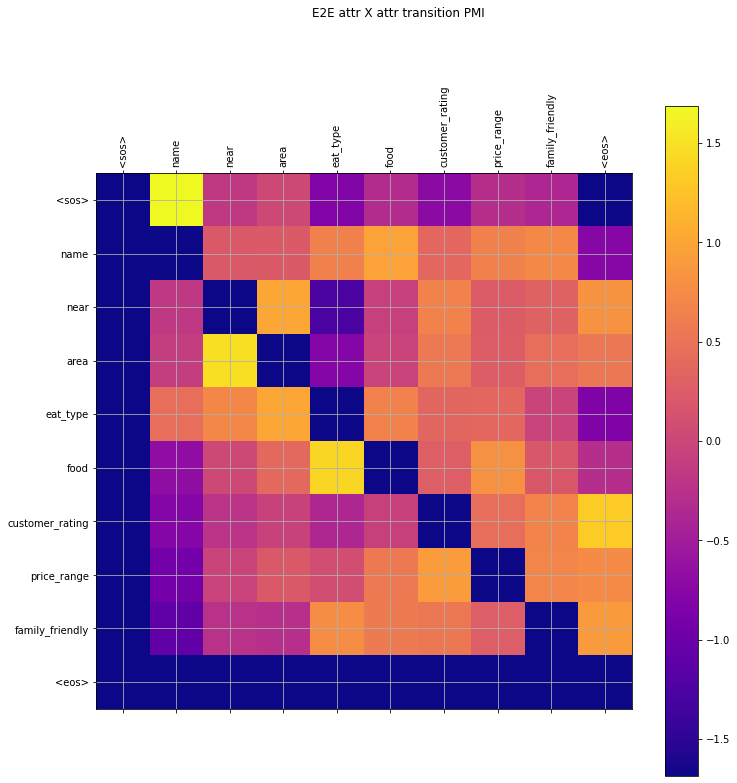

In [9]:
e2e_attrs = [
    "<sos>",
    "name",
    "near",
    "area",
    "eat_type",
    "food",
    "customer_rating",
    "price_range",
    "family_friendly",
    "<eos>"
]

pmi_e2e_a = make_pmi('E2E', include_values=False)
plot_pmi(pmi_e2e_a, e2e_attrs, "E2E attr X attr transition PMI")
plt.grid()

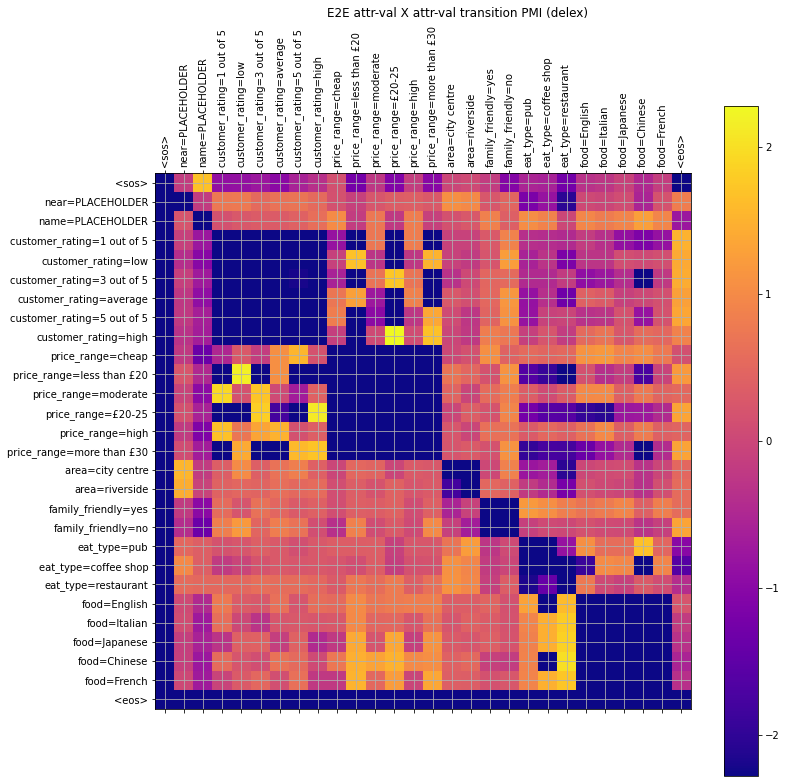

In [10]:
e2e_attrvals = [
    "<sos>",
    
    'near=PLACEHOLDER',
    'name=PLACEHOLDER',
    
    'customer_rating=1 out of 5',
    'customer_rating=low',
    'customer_rating=3 out of 5',
    'customer_rating=average',
    'customer_rating=5 out of 5',
    'customer_rating=high',
    
    'price_range=cheap',
    'price_range=less than £20',
    'price_range=moderate',
    'price_range=£20-25',
    'price_range=high',
    'price_range=more than £30',

    'area=city centre',
    'area=riverside',
    
    'family_friendly=yes',
    'family_friendly=no',
    
    'eat_type=pub',
    'eat_type=coffee shop',
    'eat_type=restaurant',
    
    'food=English',
    'food=Italian',
    'food=Japanese',
    'food=Chinese',
    'food=French',
    
    "<eos>",
]

pmi_e2e_av_delex = make_pmi('E2E')
plot_pmi(pmi_e2e_av_delex, e2e_attrvals, "E2E attr-val X attr-val transition PMI (delex)")
plt.grid()

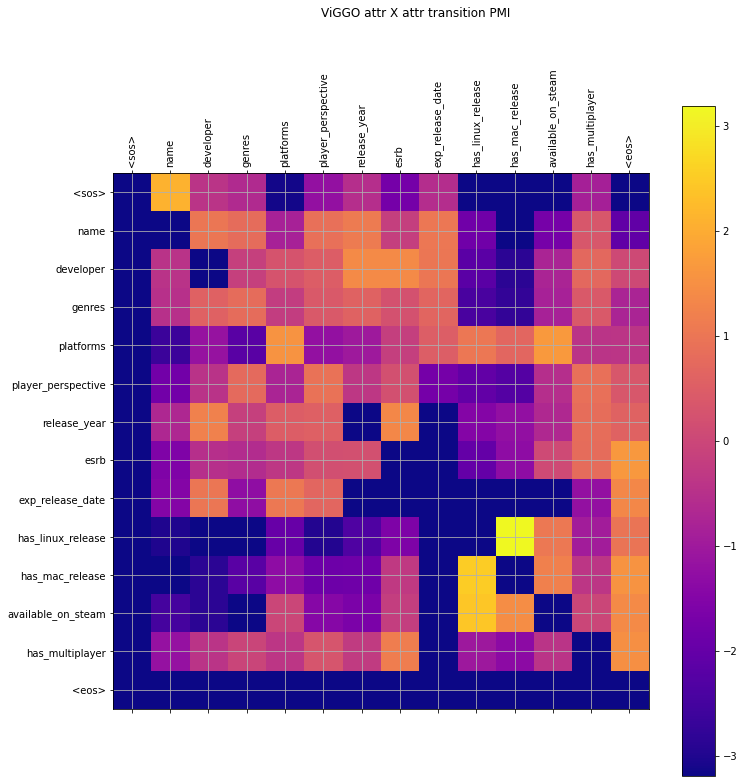

In [11]:
viggo_attrs = [
    '<sos>',
    'name',
    'developer',
    'genres',
    'platforms',
    'player_perspective',
    'release_year', 
    'esrb', 
    'exp_release_date', 
    'has_linux_release',
    'has_mac_release',    
    'available_on_steam', 
    'has_multiplayer', 
    '<eos>', 
]

pmi_viggo_a = make_pmi('ViGGO', include_values=False)
plot_pmi(pmi_viggo_a, viggo_attrs, "ViGGO attr X attr transition PMI")
plt.grid()

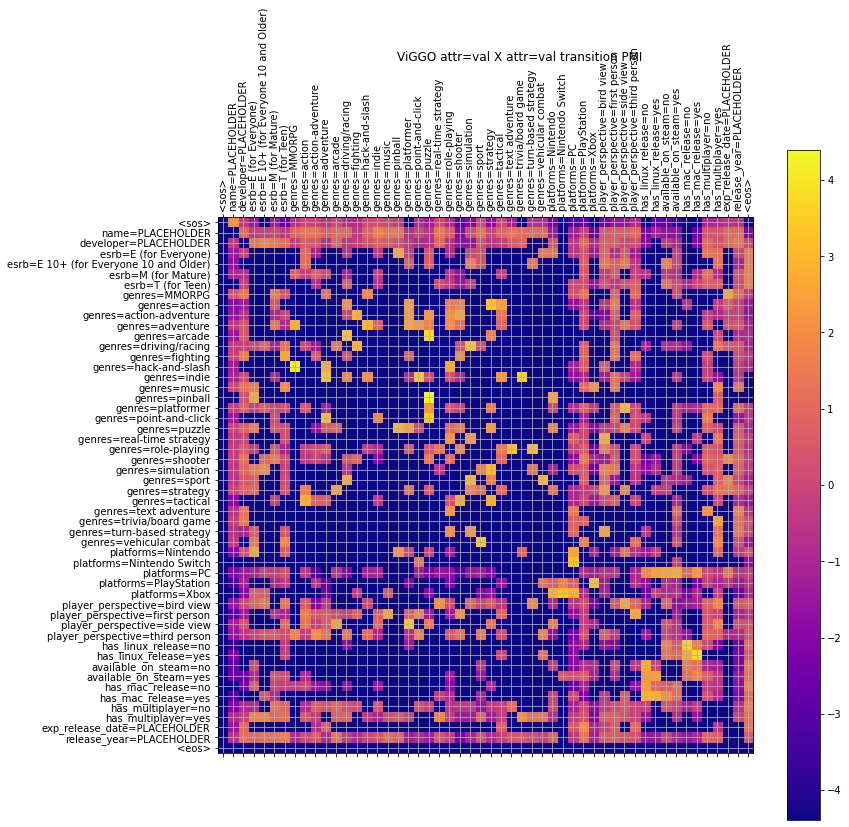

In [12]:
viggo_attrvals = [
    '<sos>', 
    
    'name=PLACEHOLDER', 
    
    'developer=PLACEHOLDER', 
    
    'esrb=E (for Everyone)', 
    'esrb=E 10+ (for Everyone 10 and Older)', 
    'esrb=M (for Mature)', 
    'esrb=T (for Teen)', 
    
    'genres=MMORPG', 
    'genres=action', 
    'genres=action-adventure', 
    'genres=adventure', 
    'genres=arcade', 
    'genres=driving/racing', 
    'genres=fighting', 
    'genres=hack-and-slash', 
    'genres=indie', 
    'genres=music', 
    'genres=pinball', 
    'genres=platformer', 
    'genres=point-and-click', 
    'genres=puzzle', 
    'genres=real-time strategy', 
    'genres=role-playing', 
    'genres=shooter', 
    'genres=simulation', 
    'genres=sport', 
    'genres=strategy', 
    'genres=tactical', 
    'genres=text adventure', 
    'genres=trivia/board game', 
    'genres=turn-based strategy', 
    'genres=vehicular combat', 
    
    'platforms=Nintendo', 
    'platforms=Nintendo Switch', 
    'platforms=PC', 
    'platforms=PlayStation', 
    'platforms=Xbox', 
    
    'player_perspective=bird view', 
    'player_perspective=first person', 
    'player_perspective=side view', 
    'player_perspective=third person',     
    
    'has_linux_release=no', 
    'has_linux_release=yes', 
    
    'available_on_steam=no', 
    'available_on_steam=yes', 
    
    'has_mac_release=no', 
    'has_mac_release=yes', 
    
    'has_multiplayer=no', 
    'has_multiplayer=yes', 

    'exp_release_date=PLACEHOLDER', 
    'release_year=PLACEHOLDER',
    
    '<eos>', 
]


pmi_viggo_av_delex = make_pmi('ViGGO')
plot_pmi(pmi_viggo_av_delex, viggo_attrvals, "ViGGO attr=val X attr=val transition PMI")
plt.grid()

# ignore remaining cells.

In [6]:
attr_pairs = len(attr2vals) * (len(attr2vals) - 1)


attr_val_pairs = 0
attr_val_pairs_delex = 0
for a1, a2 in permutations(list(attr2vals.keys()), 2):
    attr_val_pairs += len(attr2vals[a1]) * len(attr2vals[a2])
    attr_val_pairs_delex += (1 if a1 in ['name', 'near'] else len(attr2vals[a1])) \
        * (1 if a2 in ['name', 'near'] else len(attr2vals[a2]))
print(attr_val_pairs)
print(attr_val_pairs_delex)

tot_ex = 0
tot_ex_delex = 0
attrs = list(attr2vals.keys())
attrs.pop(attrs.index('name'))
for size in range(2,5):
    for p in permutations(attrs, size):
        #print(a1, len(attr2vals[a1]), a2, len(attr2vals[a2]))
        
        v = len(attr2vals['name']) * (size + 1) 
        for a in p:
            v *= len(attr2vals[a]) 
        tot_ex += v
        
        v = (size + 1) 
        for a in p:
            v *= (1 if a == 'near' else len(attr2vals[a])) 
        tot_ex_delex += v
        
        
print(tot_ex)        
print(tot_ex_delex)
print(len(e2e_train))

    
    
    

5028
780
175601160
951336
33523
